In [189]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None, 'display.max_rows', 100) 

from os import path
import pickle

import sys
sys.path.append('..')
import src.functions.my_functions as my_func

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics.scorer import make_scorer

from sklearn.metrics import f1_score, recall_score, precision_score, fbeta_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectFromModel, SelectKBest, SelectPercentile, RFECV, f_classif

from sklearn.decomposition import PCA

from sklearn.ensemble import AdaBoostClassifier

In [2]:
from imp import reload
reload(my_func)

<module 'src.functions.my_functions' from '..\\src\\functions\\my_functions.py'>

### Import Data

In [3]:
data = {}

ds = ['train', 'train_target', 'test', 'test_target']
d = ['..', 'data', 'processed']

for s in ds:    
    fn = 'loan_'+s+'.p'
    fp = path.join(*d, fn)

    with open(fp, 'rb') as file:
        data[s] = pickle.load(file)

In [4]:
data['train'].shape, data['train_target'].shape

((152218, 47), (152218, 2))

In [5]:
data['test'].shape, data['test_target'].shape

((38055, 47), (38055, 2))

### Data Prep

In [6]:
# Columns identified thus far as best for classification (during data prep, select K best)
num_attr = ['funded_amnt_q10', 'int_rate_delta', 'annual_inc_q10', 'dti', 'delinq_2yrs', 'inq_last_6mths',
            'open_acc', 'revol_bal_log', 'revol_util', 'total_acc', 'collections_12_mths_ex_med',
            'acc_now_delinq', 'rev_lim_sqrt', 'tot_cur_bal', 'tot_coll_amt', 'subgrade_p_value',
            'lti', 'rbti', 'tbti', 'cr_line_td_log', 'emp_length_val']

bin_attr = ['had_delinq', 'had_major_derog', 'had_record', 'verified', 'term_bin']

cat_attr = ['purpose', 'home_ownership']

In [7]:
num_prep = Pipeline([('custom', my_func.CustomNumAttributes()), # Create custom num attr
                     ('select', my_func.DataFrame_Selector(num_attr)), # Select num columns
                     ('sc', StandardScaler())]) # Scale data

bin_prep = Pipeline([('custom', my_func.CustomBinAttributes()), # Create custom bin attr
                     ('select', my_func.DataFrame_Selector(bin_attr))]) # Select binary columns

cat_prep = Pipeline([('encode', my_func.DataFrame_DummyEncoder(cat_attr))]) # Select & encode categrocial columns

feature_prep = FeatureUnion([('num', num_prep),
                             ('bin', bin_prep),
                             ('cat', cat_prep)])

In [8]:
X_train_full = feature_prep.fit_transform(data['train'])
X_test = feature_prep.transform(data['test'])

y_train_full = data['train_target']['default']
y_test = data['test_target']['default']

In [9]:
def get_feature_prep_columns(feature_union):
    num_cols = feature_union.transformer_list[0][1].named_steps['select'].get_feature_names()
    bin_cols = feature_union.transformer_list[1][1].named_steps['select'].get_feature_names()
    cat_cols = feature_union.transformer_list[2][1].named_steps['encode'].get_feature_names()
    cols = num_cols + bin_cols + cat_cols
    return cols

In [10]:
feature_names = get_feature_prep_columns(feature_prep)
len(feature_names)

44

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

### Scoring

F2 scorer, as used in previous notebooks:

In [12]:
f2_score = make_scorer(fbeta_score, beta=2)

### OneR Baseline

In [336]:
oner = DecisionTreeClassifier(class_weight='balanced', max_depth=1)
oner.fit(X_train, y_train);

In [23]:
oner_cvs = cross_val_score(oner, X_train, y_train, cv=5, scoring=f2_score)
my_func.print_cvs(oner_cvs, 'f2')

Mean f2 score = 0.525 (+\- 0.010)


In [17]:
my_func.classifier_summary(y_train, oner.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               58462               39852
Actual Positive                7996               15464
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.518383
Recall           0.659165
Precision (pos)  0.279557
Precision (neg)  0.879683
Specificity      0.594646


In [19]:
my_func.classifier_summary(y_val, oner.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               14564               10066
Actual Positive                2017                3797
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.511463
Recall           0.653079
Precision (pos)  0.273895
Precision (neg)  0.878355
Specificity      0.591311


### Decision Tree

##### Parameter Tuning

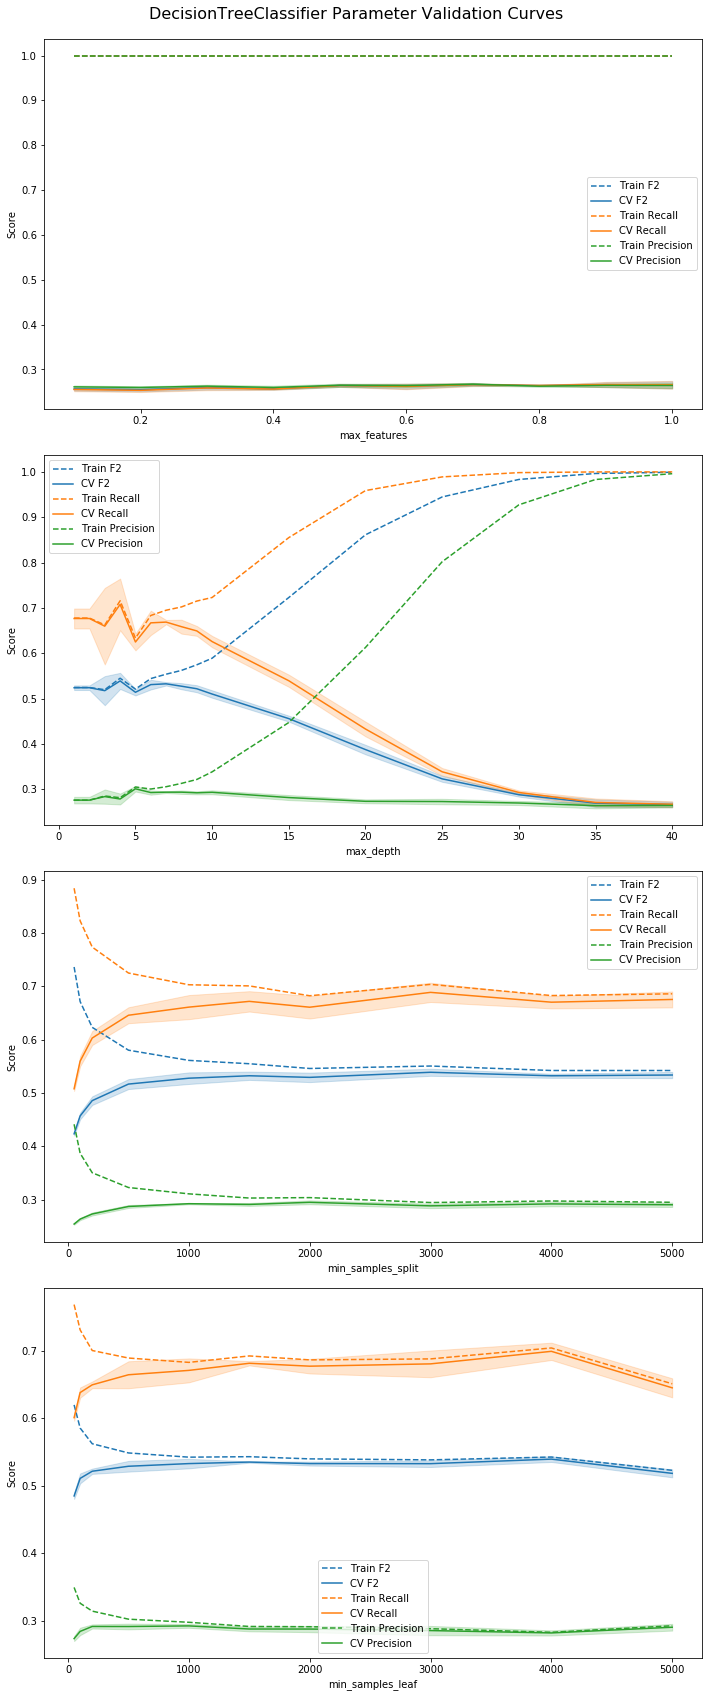

In [442]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision'}

param_grid = {'max_features': np.arange(0.1,1.1,0.1),
              'max_depth': np.concatenate((np.arange(1,10,1), np.arange(10,41,5))),
              'min_samples_split': [50, 100, 200, 500, 1000, 1500, 2000, 3000, 4000, 5000],
              'min_samples_leaf': [50, 100, 200, 500, 1000, 1500, 2000, 3000, 4000, 5000]}

dtc_param_summary =  my_func.plot_validation_curves(DecisionTreeClassifier(class_weight='balanced', random_state=42), X_train, y_train, param_grid=param_grid, scoring=scoring, n_jobs=4, title='DecisionTreeClassifier Parameter Validation Curves', ncols=1, plotsize=(10,6))

Tuning all parameters at once may lead to our various constraints conflicting with one another, and also increases the liklihood of overfitting/tuning for our training set. For the sake of both computational complexity in our tuning and trying to obtain flexible models, we will take a more procedural approach to parameter tuning and try and identify a subset of parameters that serve us best.

We will begin with the combination min_samples_split, max_features, and max_depth, excluding min_samples_leaf for the time being. Additionally, we will compare peformance of the splitting measure (gini vs. entropy):

In [17]:
DecisionTreeClassifier?

In [18]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

md = np.concatenate((np.array([None,]), np.arange(1,21,1)))
mf = np.arange(0.1,1.0,0.1)

param_grid = {'max_depth': md,
              'max_features': mf,
              'criterion': ['gini', 'entropy']}

dtc_test = DecisionTreeClassifier(class_weight='balanced')
              
dtc_gs_md = GridSearchCV(estimator=dtc_test,
                              param_grid=param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4,
                              verbose=2)

my_func.run_time(reset=True)
dtc_gs_md.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 378 candidates, totalling 1134 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   18.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   37.5s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  4.7min


Time: 5min 44s 


[Parallel(n_jobs=4)]: Done 1134 out of 1134 | elapsed:  5.7min finished


In [19]:
my_func.gs_score_summary(dtc_gs_md);

--------------------
Best F2:
Params: {'criterion': 'gini', 'max_depth': 4, 'max_features': 0.40000000000000002}
F2 = 0.5485569910000739
Recall = 0.7407075282260539
Precision = 0.2701049837218982
Specificity = 0.5209430777969837
--------------------
Best Recall:
Params: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 0.40000000000000002}
F2 = 0.540008216277874
Recall = 0.7484655466541369
Precision = 0.25620376519137983
Specificity = 0.47932136965692473
--------------------
Best Precision:
Params: {'criterion': 'gini', 'max_depth': 7, 'max_features': 0.80000000000000004}
F2 = 0.5185825236826632
Recall = 0.6333330154971999
Precision = 0.3014083932847019
Specificity = 0.6492157174517293
--------------------
Best Specificity:
Params: {'criterion': 'gini', 'max_depth': None, 'max_features': 0.40000000000000002}
F2 = 0.2572811697967543
Recall = 0.25579705489398263
Precision = 0.26341837494085546
Specificity = 0.8293325424858066
--------------------


In [45]:
dtc_test = DecisionTreeClassifier(class_weight='balanced',
                                  criterion='gini',
                                  max_depth=4,
                                  max_features=0.4)

dtc_test.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4,
            max_features=0.4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [54]:
my_func.print_cvs(cross_val_score(dtc_test, X_train, y_train, cv=5, scoring='recall'))

Mean CV score = 0.685 (+/- 0.053)


We appear to have a lot of variability in our scores between different fits. We will see if fixing the random state yields improvements:

In [56]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

rs = np.random.choice(1000, 100, replace=False)

param_grid = {'random_state': rs}

dtc_test = DecisionTreeClassifier(class_weight='balanced',
                                  criterion='gini',
                                  max_depth=4,
                                  max_features=0.4)
              
dtc_gs_md_rs = GridSearchCV(estimator=dtc_test,
                              param_grid=param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4,
                              verbose=2)

my_func.run_time(reset=True)
dtc_gs_md_rs.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   31.3s


Time: 54.80s 


[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   54.5s finished


In [58]:
my_func.gs_score_summary(dtc_gs_md_rs);

--------------------
Best F2:
Params: {'random_state': 356}
F2 = 0.5540412946595431
Recall = 0.7485931046556958
Precision = 0.27195957615302857
Specificity = 0.5215126608427032
--------------------
Best Recall:
Params: {'random_state': 356}
F2 = 0.5540412946595431
Recall = 0.7485931046556958
Precision = 0.27195957615302857
Specificity = 0.5215126608427032
--------------------
Best Precision:
Params: {'random_state': 991}
F2 = 0.46061835569307596
Recall = 0.5279622534167419
Precision = 0.30542484837014944
Specificity = 0.7135606094668682
--------------------
Best Specificity:
Params: {'random_state': 991}
F2 = 0.46061835569307596
Recall = 0.5279622534167419
Precision = 0.30542484837014944
Specificity = 0.7135606094668682
--------------------


In [63]:
dtc_test = DecisionTreeClassifier(class_weight='balanced',
                                  criterion='gini',
                                  max_depth=4,
                                  max_features=0.4,
                                  random_state=356)

dtc_test.fit(X_train, y_train);

In [64]:
my_func.print_cvs(cross_val_score(dtc_test, X_train, y_train, cv=5, scoring='recall'), 'recall')

Mean recall score = 0.740 (+/- 0.024)


In [65]:
my_func.classifier_summary(y_train, dtc_test.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               52422               45892
Actual Positive                5951               17509
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.556757
Recall           0.746334
Precision (pos)  0.276163
Precision (neg)  0.898052
Specificity      0.533210


In [66]:
my_func.classifier_summary(y_val, dtc_test.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               13134               11496
Actual Positive                1507                4307
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.551345
Recall           0.740798
Precision (pos)  0.272543
Precision (neg)  0.897070
Specificity      0.533252


These results are much more promising. Next, we will see if the addition of other paramters (min_samples_split and min_samples_leaf) can yield any additional improvements:

In [67]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

mss = np.concatenate((np.arange(.001,.01,.0005), np.arange(0.01,0.1,0.005)))
msl = mss

param_grid = {'min_samples_split': mss,
              'min_samples_leaf': msl}

dtc_test = DecisionTreeClassifier(class_weight='balanced',
                                  criterion='gini',
                                  max_depth=4,
                                  max_features=0.4)
              
dtc_gs_ms = GridSearchCV(estimator=dtc_test,
                              param_grid=param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4,
                              verbose=2)

my_func.run_time(reset=True)
dtc_gs_ms.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   31.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:  5.6min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:  7.2min
[Parallel(n_jobs=4)]: Done 3273 tasks      | elapsed:  9.0min


Time: 10min 34s 


[Parallel(n_jobs=4)]: Done 3888 out of 3888 | elapsed: 10.6min finished


In [68]:
dtc_gs_ms_summary = my_func.gs_score_summary(dtc_gs_ms);

--------------------
Best F2:
Params: {'min_samples_leaf': 0.0050000000000000001, 'min_samples_split': 0.0095000000000000015}
F2 = 0.547279231642619
Recall = 0.7394715734152953
Precision = 0.2686986721082035
Specificity = 0.5188274777160775
--------------------
Best Recall:
Params: {'min_samples_leaf': 0.089999999999999983, 'min_samples_split': 0.039999999999999994}
F2 = 0.534934832992416
Recall = 0.7491902896972745
Precision = 0.24989536330393622
Specificity = 0.4630165306597024
--------------------
Best Precision:
Params: {'min_samples_leaf': 0.0090000000000000011, 'min_samples_split': 0.0055000000000000005}
F2 = 0.479609518615379
Recall = 0.5624886644863107
Precision = 0.30561185011418984
Specificity = 0.6931564979335814
--------------------
Best Specificity:
Params: {'min_samples_leaf': 0.0045000000000000005, 'min_samples_split': 0.074999999999999983}
F2 = 0.4611640352701931
Recall = 0.5322254598336267
Precision = 0.3024192741694481
Specificity = 0.705840554149595
-----------------

In [70]:
dtc_test = DecisionTreeClassifier(class_weight='balanced',
                                  criterion='gini',
                                  max_depth=4,
                                  max_features=0.4,
                                  min_samples_split=0.0095,
                                  min_samples_leaf=0.005)

dtc_test.fit(X_train, y_train);

In [73]:
my_func.print_cvs(cross_val_score(dtc_test, X_train, y_train, cv=5, scoring='recall'), 'recall')

Mean recall score = 0.600 (+/- 0.056)


Again we see a significant variance in scores on subsequent runthroughs. We will see if we can find an optimal random state again for this new set of parameters:

In [75]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

rs = np.random.choice(1000, 200, replace=False)

param_grid = {'random_state': rs}

dtc_test = DecisionTreeClassifier(class_weight='balanced',
                                  criterion='gini',
                                  max_depth=4,
                                  max_features=0.4,
                                  min_samples_split=0.0095,
                                  min_samples_leaf=0.005)
              
dtc_gs_ms_rs = GridSearchCV(estimator=dtc_test,
                              param_grid=param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4,
                              verbose=2)

my_func.run_time(reset=True)
dtc_gs_ms_rs.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   30.9s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  1.0min


Time: 1min 40s 


[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:  1.7min finished


In [76]:
my_func.gs_score_summary(dtc_gs_ms_rs);

--------------------
Best F2:
Params: {'random_state': 448}
F2 = 0.5483390690851847
Recall = 0.7319268846398072
Precision = 0.2741097938868561
Specificity = 0.5367700109303601
--------------------
Best Recall:
Params: {'random_state': 150}
F2 = 0.5476168140029026
Recall = 0.7386189793872906
Precision = 0.2706950026458119
Specificity = 0.5227739955692572
--------------------
Best Precision:
Params: {'random_state': 817}
F2 = 0.5002213717279292
Recall = 0.5971442486410511
Precision = 0.30371599575206154
Specificity = 0.6729764273472938
--------------------
Best Specificity:
Params: {'random_state': 287}
F2 = 0.4551944710898601
Recall = 0.5272803468435112
Precision = 0.29442107854757094
Specificity = 0.6984457803049889
--------------------


In [77]:
dtc_test = DecisionTreeClassifier(class_weight='balanced',
                                  criterion='gini',
                                  max_depth=4,
                                  max_features=0.4,
                                  min_samples_split=0.0095,
                                  min_samples_leaf=0.005,
                                  random_state=448)

dtc_test.fit(X_train, y_train);

In [78]:
my_func.print_cvs(cross_val_score(dtc_test, X_train, y_train, cv=5, scoring='recall'), 'recall')

Mean recall score = 0.732 (+/- 0.019)


In [79]:
my_func.classifier_summary(y_train, dtc_test.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               54430               43884
Actual Positive                6604               16856
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.545219
Recall           0.718500
Precision (pos)  0.277511
Precision (neg)  0.891798
Specificity      0.553634


In [80]:
my_func.classifier_summary(y_val, dtc_test.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               13573               11057
Actual Positive                1678                4136
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.537855
Recall           0.711386
Precision (pos)  0.272231
Precision (neg)  0.889974
Specificity      0.551076


Compared to our model without min_samples_split/min_samples_leaf, we see a slight reducton in performance for recall. The addition of both of these minimum sample constaints may be leading to overfitting our training set, so perhaps singling out the use of one over the other will yield improvements. Note that we will also add in min_impurity_increase to see if this provides a better alternative to our two min sample parameters:

In [95]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

mss = np.concatenate((np.arange(.001,.01,.0005), np.arange(0.01,0.1,0.005)))
msl = mss
mid = np.concatenate((np.arange(.0001,.001,.00005), np.arange(.001,.01,.0005)))

param_grid = [{'min_samples_split': mss},
              {'min_samples_leaf': msl},
              {'min_impurity_decrease': mid}]

dtc_test = DecisionTreeClassifier(class_weight='balanced',
                                  criterion='gini',
                                  max_depth=4,
                                  max_features=0.4)
              
dtc_gs_mins = GridSearchCV(estimator=dtc_test,
                              param_grid=param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4,
                              verbose=2)

my_func.run_time(reset=True)
dtc_gs_mins.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   30.9s


Time: 55.83s 


[Parallel(n_jobs=4)]: Done 324 out of 324 | elapsed:   55.6s finished


In [96]:
dtc_gs_mins_summary = my_func.gs_score_summary(dtc_gs_mins)

--------------------
Best F2:
Params: {'min_samples_split': 0.0055000000000000005}
F2 = 0.5455834951514376
Recall = 0.7430516299175988
Precision = 0.2660851930282314
Specificity = 0.5079336568746841
--------------------
Best Recall:
Params: {'min_impurity_decrease': 0.0035000000000000001}
F2 = 0.5444351008151741
Recall = 0.7634274376116723
Precision = 0.2553175214800269
Specificity = 0.4653865244181512
--------------------
Best Precision:
Params: {'min_impurity_decrease': 0.00095000000000000021}
F2 = 0.45478325161445476
Recall = 0.5195218474607504
Precision = 0.3067439928650994
Specificity = 0.7199278925311328
--------------------
Best Specificity:
Params: {'min_impurity_decrease': 0.00095000000000000021}
F2 = 0.45478325161445476
Recall = 0.5195218474607504
Precision = 0.3067439928650994
Specificity = 0.7199278925311328
--------------------


In [98]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

rs = np.random.choice(1000, 200, replace=False)

param_grid = {'random_state': rs}

dtc_test = DecisionTreeClassifier(class_weight='balanced',
                                  criterion='gini',
                                  max_depth=4,
                                  max_features=0.4,
                                  min_samples_split=0.0055)
              
dtc_gs_rs = GridSearchCV(estimator=dtc_test,
                              param_grid=param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4,
                              verbose=2)

my_func.run_time(reset=True)
dtc_gs_rs.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   12.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   31.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  1.0min


Time: 1min 40s 


[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:  1.7min finished


In [99]:
my_func.gs_score_summary(dtc_gs_rs);

--------------------
Best F2:
Params: {'random_state': 913}
F2 = 0.55254976418357
Recall = 0.7654730386678741
Precision = 0.2616473889455405
Specificity = 0.4844884682054741
--------------------
Best Recall:
Params: {'random_state': 913}
F2 = 0.55254976418357
Recall = 0.7654730386678741
Precision = 0.2616473889455405
Specificity = 0.4844884682054741
--------------------
Best Precision:
Params: {'random_state': 106}
F2 = 0.4847925014223288
Recall = 0.5647061270307576
Precision = 0.3117903038831682
Specificity = 0.701131125832842
--------------------
Best Specificity:
Params: {'random_state': 106}
F2 = 0.4847925014223288
Recall = 0.5647061270307576
Precision = 0.3117903038831682
Specificity = 0.701131125832842
--------------------


In [100]:
dtc_test = DecisionTreeClassifier(class_weight='balanced',
                                  criterion='gini',
                                  max_depth=4,
                                  max_features=0.4,
                                  min_samples_split=0.0055,
                                  random_state=913)

dtc_test.fit(X_train, y_train);

In [101]:
my_func.print_cvs(cross_val_score(dtc_test, X_train, y_train, cv=5, scoring='recall'), 'recall')

Mean recall score = 0.756 (+/- 0.021)


In [102]:
my_func.classifier_summary(y_train, dtc_test.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               50638               47676
Actual Positive                5965               17495
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.550119
Recall           0.745737
Precision (pos)  0.268448
Precision (neg)  0.894617
Specificity      0.515064


In [103]:
my_func.classifier_summary(y_val, dtc_test.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               12688               11942
Actual Positive                1503                4311
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.545572
Recall           0.741486
Precision (pos)  0.265243
Precision (neg)  0.894088
Specificity      0.515144


Whilst we see very slight improvements to recall, there has been a noticeable hit to specificity on the magnitude of 0.02-0.03. Consequently, our best decision tree model appears to be acheived with max_depth alone.

In [105]:
dtc_best = DecisionTreeClassifier(class_weight='balanced',
                                  criterion='gini',
                                  max_depth=4,
                                  max_features=0.4,
                                  random_state=356)

dtc_best.fit(X_train, y_train); 

##### Learning Curve

Based off the differences in performance between our cross validation and train/validation scores, we should see how the sample sizes impact model performance:

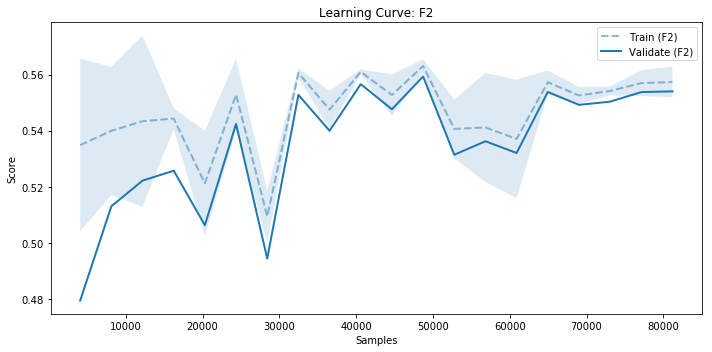

In [106]:
my_func.plot_learning_curve(estimator=dtc_best, X=X_train, y=y_train, scoring='f2', train_sizes=np.arange(0.05,1.01,0.05),n_jobs=4)

It is clear that the decision tree classifier is very volatile until we reach approx. 65,000 samples, after which we seem to have a more consistent performance.

### Random Forest Classifier

##### Basic Model

We will start with a collection of 100 decision stumps as a basic model for comparison:

In [107]:
rfc_basic = RandomForestClassifier(class_weight='balanced', max_depth=1, n_estimators=100)
rfc_basic.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=1, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [108]:
my_func.print_cvs(cross_val_score(rfc_basic, X_train, y_train, scoring=f2_score))

Mean CV score = 0.518 (+/- 0.010)


In [109]:
my_func.classifier_summary(y_train, rfc_basic.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               62002               36312
Actual Positive                8236               15224
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.523608
Recall           0.648934
Precision (pos)  0.295405
Precision (neg)  0.882742
Specificity      0.630653


In [110]:
my_func.classifier_summary(y_val, rfc_basic.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               15588                9042
Actual Positive                2057                3757
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.521010
Recall           0.646199
Precision (pos)  0.293539
Precision (neg)  0.883423
Specificity      0.632887


This ensemble of decision stumps does not appear to perform much better than our single OneR model.

Alternatively, we can create an ensemble of our optimized decision tree:

In [122]:
rfc_basic_v2 = RandomForestClassifier(class_weight='balanced',
                                      criterion='gini',
                                      max_depth=4,
                                      max_features=0.4,
                                      n_estimators=100)
rfc_basic_v2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=4, max_features=0.4,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [119]:
my_func.print_cvs(cross_val_score(rfc_basic_v2, X_train, y_train, cv=5, scoring=f2_score))

Mean CV score = 0.538 (+/- 0.004)


In [120]:
my_func.classifier_summary(y_train, rfc_basic_v2.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               59862               38452
Actual Positive                7427               16033
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.540469
Recall           0.683419
Precision (pos)  0.294264
Precision (neg)  0.889625
Specificity      0.608886


In [121]:
my_func.classifier_summary(y_val, rfc_basic_v2.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               14990                9640
Actual Positive                1868                3946
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.535530
Recall           0.678707
Precision (pos)  0.290446
Precision (neg)  0.889192
Specificity      0.608607


Compared to our singular decision tree, is performance is actually significantly worse. The random forest as a whole performs rather consistently consideing the variance on our CV scores, but we are likely building less than ideal trees within our ensemble since we have re-introduced the randomness in how these trees are built versus our fixed random_state in the singular tree.

Perhaps a better combination parameters can be found which suits the nature of random forests versus our singular tree.

##### Learning Curve

For the decision stump ensemble:

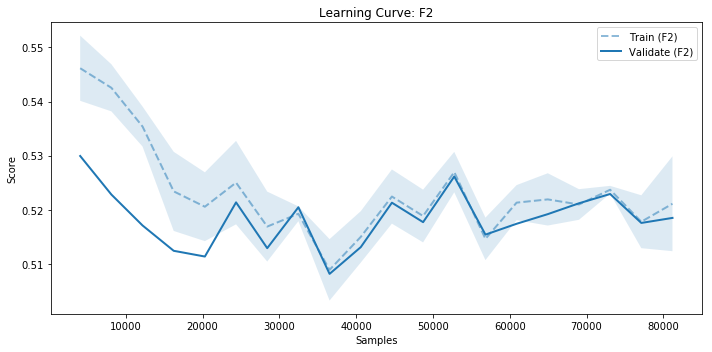

In [111]:
my_func.plot_learning_curve(estimator=rfc_basic, X=X_train, y=y_train, scoring='f2', train_sizes=np.arange(0.05,1.01,0.05),n_jobs=4)

For the optimized decision tree ensemble:

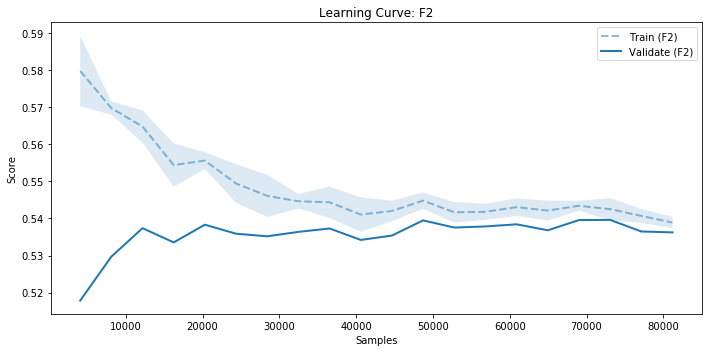

In [124]:
my_func.plot_learning_curve(estimator=rfc_basic_v2, X=X_train, y=y_train, scoring='f2', train_sizes=np.arange(0.05,1.01,0.05),n_jobs=4)

Our collection of optimized decision trees is clearly more stable past the 20,000 sample mark, whereas the stumps appear to be extremely volatile in performance across all sample ranges. Assuming we find a similar optimized model to our best decision tree, this bodes well for possible collections relying on smaller training sets (i.e. boosting/pasting methods).

##### Parameter Tuning

C:\Users\David\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\David\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\David\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\David\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\David\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

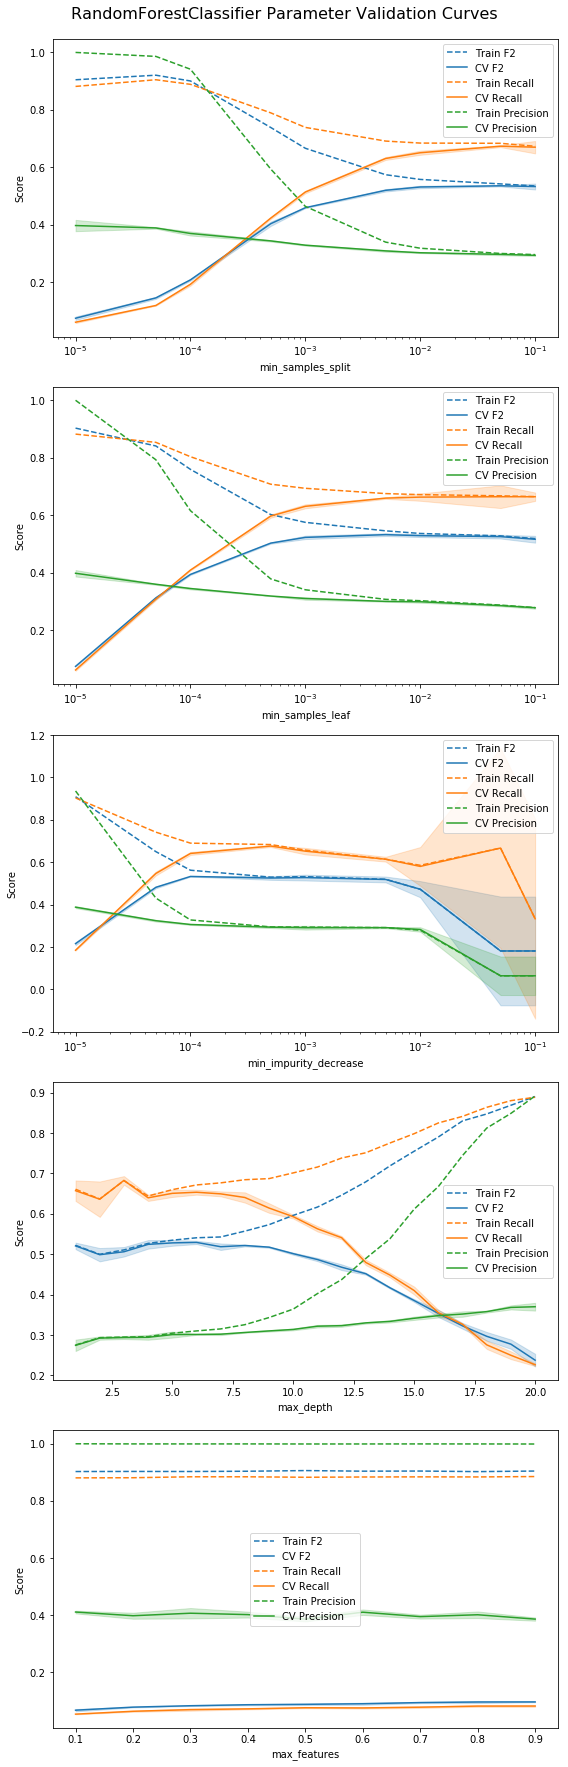

In [129]:
scoring={'f2': f2_score,
         'recall':'recall',
         'precision':'precision'}

mss = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
msl = mss
mid = mss
md = np.arange(1,21,1)
mf = np.arange(0.1,1.0,0.1)

param_grid = {'min_samples_split': mss,
              'min_samples_leaf': msl,
              'min_impurity_decrease': mid,
              'max_depth': md,
              'max_features': mf}


rfc_param_summary = my_func.plot_validation_curves(RandomForestClassifier(class_weight='balanced'),
                                                   X_train, y_train, param_grid=param_grid, scoring=scoring, n_jobs=4,
                                                   log=['min_samples_split', 'min_samples_leaf', 'min_impurity_decrease'],
                                                   title='RandomForestClassifier Parameter Validation Curves',
                                                   ncols=1)

We will start as we did with the decision tree by focusing on max depth and max features:

In [130]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

md = np.arange(1,11,1)
mf = np.arange(0.1,1.0,0.1)

param_grid = {'max_depth': md,
              'max_features': mf,
              'criterion': ['gini', 'entropy']}

rfc_test = RandomForestClassifier(class_weight='balanced')

rfc_gs_md = GridSearchCV(estimator=rfc_test,
                          param_grid = param_grid,
                          scoring=scoring,
                          cv=3,
                          refit=False,
                          n_jobs=4,
                          verbose=2)

my_func.run_time(reset=True)
rfc_gs_md.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   18.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  4.2min


Time: 7min 45s 


[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  7.7min finished


In [131]:
rfc_gs_md_summary = my_func.gs_score_summary(rfc_gs_md)

--------------------
Best F2:
Params: {'criterion': 'gini', 'max_depth': 5, 'max_features': 0.70000000000000007}
F2 = 0.5404795970628247
Recall = 0.680051165596812
Precision = 0.29685562795416587
Specificity = 0.6155583324780299
--------------------
Best Recall:
Params: {'criterion': 'entropy', 'max_depth': 1, 'max_features': 0.90000000000000002}
F2 = 0.5299576959835566
Recall = 0.6953538948528902
Precision = 0.27212768427689976
Specificity = 0.5554346710984589
--------------------
Best Precision:
Params: {'criterion': 'gini', 'max_depth': 10, 'max_features': 0.5}
F2 = 0.5057018213850206
Recall = 0.5918157685674654
Precision = 0.3196762121176034
Specificity = 0.6994731095810173
--------------------
Best Specificity:
Params: {'criterion': 'gini', 'max_depth': 10, 'max_features': 0.59999999999999998}
F2 = 0.5006518044137723
Recall = 0.5837168792871387
Precision = 0.31906458820764905
Specificity = 0.7027483308303694
--------------------


Our best set of parameters has not performed nearly as well as one might have hoped. Perhaps another constraint performs better than max_depth (again, in combination with max_features):

In [133]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

mss = np.concatenate((np.arange(.001,.01,.0005), np.arange(0.01,0.1,0.005)))
msl = mss
mid = np.concatenate((np.arange(0.0001, 0.001, 0.00005), np.arange(0.001, 0.0101, 0.0005)))
mf = np.arange(0.1,1.0,0.1)

param_grid = [{'min_impurity_decrease': mid, 'max_features': mf},
              {'min_samples_split': mss, 'max_features': mf},
              {'min_samples_leaf': msl, 'max_features': mf},
              {'max_depth': md, 'max_features': mf}]

rfc_test = RandomForestClassifier(class_weight='balanced')

rfc_gs = GridSearchCV(estimator=rfc_test,
                              param_grid = param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4,
                              verbose=1)

my_func.run_time(reset=True)
rfc_gs.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 1071 candidates, totalling 3213 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  7.3min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 12.5min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 22.7min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 31.3min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 42.1min


Time: 42min 38s 


[Parallel(n_jobs=4)]: Done 3213 out of 3213 | elapsed: 42.6min finished


In [134]:
rfc_gs_summary = my_func.gs_score_summary(rfc_gs)

--------------------
Best F2:
Params: {'max_features': 0.5, 'min_samples_leaf': 0.094999999999999987}
F2 = 0.543131438341196
Recall = 0.7155157428227386
Precision = 0.2766320869856541
Specificity = 0.5534512011664803
--------------------
Best Recall:
Params: {'max_features': 0.30000000000000004, 'min_impurity_decrease': 0.010000000000000002}
F2 = 0.5389462554285803
Recall = 0.730306719499713
Precision = 0.26494879932161536
Specificity = 0.5134771870854191
--------------------
Best Precision:
Params: {'max_features': 0.5, 'min_samples_split': 0.001}
F2 = 0.45097805435844995
Recall = 0.49471432279250105
Precision = 0.3331631012444551
Specificity = 0.7637264306686935
--------------------
Best Specificity:
Params: {'max_features': 0.80000000000000004, 'min_samples_split': 0.001}
F2 = 0.44376087446951007
Recall = 0.4841005771582148
Precision = 0.3328267071857979
Specificity = 0.7684358314800841
--------------------


Min samples per leaf appears to yield our best F2 score. Let's take a look at the top 10 models from this grid search:

In [135]:
rfc_gs_summary.sort_values('F2', ascending=False)[:10]

,F2,precision,recall,specificity,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_samples_split
836,0.543131,0.276632,0.715516,0.553451,NaN,0.5,NaN,0.095,NaN
82,0.542133,0.288427,0.695013,0.590770,NaN,0.3,0.0005,NaN,NaN
749,0.541387,0.293062,0.686914,0.604604,NaN,0.3,NaN,0.020,NaN
470,0.541239,0.288675,0.693350,0.592021,NaN,0.4,NaN,NaN,0.065
121,0.541129,0.290281,0.690281,0.597209,NaN,0.4,0.0006,NaN,NaN
119,0.540801,0.290454,0.689471,0.598053,NaN,0.4,0.0005,NaN,NaN
428,0.540569,0.295146,0.682438,0.611093,NaN,0.3,NaN,NaN,0.035
434,0.540549,0.291108,0.688065,0.600016,NaN,0.3,NaN,NaN,0.065
570,0.540389,0.300748,0.674851,0.625547,NaN,0.7,NaN,NaN,0.025
191,0.539621,0.296185,0.679199,0.614877,NaN,0.6,0.0004,NaN,NaN


Min impurity decrease ix a close second, but there is little reason to ignore out best performing parameter set. We will see how this model performs with CV scoring and train/test evaluation:

In [136]:
rfc_test = RandomForestClassifier(class_weight='balanced', 
                                  max_features=0.5,
                                  min_samples_leaf=.095,
                                  n_estimators=100)
rfc_test.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=0.095,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [137]:
my_func.print_cvs(cross_val_score(rfc_test, X_train, y_train, cv=5, scoring=f2_score))

Mean CV score = 0.532 (+/- 0.004)


In [138]:
my_func.classifier_summary(y_train, rfc_test.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               56212               42102
Actual Positive                7243               16217
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.532897
Recall           0.691262
Precision (pos)  0.278074
Precision (neg)  0.885856
Specificity      0.571760


In [139]:
my_func.classifier_summary(y_val, rfc_test.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               14038               10592
Actual Positive                1832                3982
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.526302
Recall           0.684899
Precision (pos)  0.273226
Precision (neg)  0.884562
Specificity      0.569955


The model appears to perform slightly worse than the scores seen with our grid search. Perhaps the addition of other parameters can yield improvements:

In [140]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

mss = np.concatenate((np.arange(.001,.01,.0005), np.arange(0.01,0.1,0.005)))
msl = mss
mid = np.concatenate((np.arange(0.0001, 0.001, 0.00005), np.arange(0.001, 0.0101, 0.0005)))
mf = np.arange(0.1,1.0,0.1)

param_grid = [{'min_impurity_decrease': mid},
              {'min_samples_split': mss},
              {'max_depth': md},
              {'min_samples_leaf':[0.095]}] # To include scores of our default

rfc_test = RandomForestClassifier(class_weight='balanced', 
                                  max_features=0.5,
                                  min_samples_leaf=.095)

rfc_gs_v2 = GridSearchCV(estimator=rfc_test,
                              param_grid = param_grid,
                              scoring=scoring,
                              cv=3,
                              refit=False,
                              n_jobs=4,
                              verbose=3)

my_func.run_time(reset=True)
rfc_gs_v2.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   17.6s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  1.0min


Time: 2min 7s 


[Parallel(n_jobs=4)]: Done 252 out of 252 | elapsed:  2.1min finished


In [141]:
rfc_gs_v2_summary = my_func.gs_score_summary(rfc_gs_v2)

--------------------
Best F2:
Params: {'max_depth': 5}
F2 = 0.5414031462942378
Recall = 0.7115942326519332
Precision = 0.27671204452673187
Specificity = 0.5561161301846281
--------------------
Best Recall:
Params: {'min_samples_split': 0.029999999999999999}
F2 = 0.5413606604728027
Recall = 0.7161975989902388
Precision = 0.2739570586359502
Specificity = 0.5471346718557488
--------------------
Best Precision:
Params: {'min_impurity_decrease': 0.0064999999999999997}
F2 = 0.5064626834431379
Recall = 0.6242112122758788
Precision = 0.2901138783899973
Specificity = 0.6342534767446747
--------------------
Best Specificity:
Params: {'max_depth': 1}
F2 = 0.49643453501026696
Recall = 0.6122329856192033
Precision = 0.28772839436624675
Specificity = 0.6347009542980249
--------------------


Adding a max depth of 5 yields the best results, but appears to be worse off than our previous, simpler model. For good measure we will evaluate the performance with addition of this parameter:

In [145]:
rfc_test = RandomForestClassifier(class_weight='balanced',
                                     max_features=0.5,
                                     min_samples_leaf=.095,
                                     max_depth=5,
                                     n_estimators=100)

rfc_test.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=0.095,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [144]:
my_func.print_cvs(cross_val_score(rfc_test, X_train, y_train, cv=5, scoring=f2_score))

Mean CV score = 0.532 (+/- 0.006)


In [146]:
my_func.classifier_summary(y_train, rfc_test.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               56655               41659
Actual Positive                7400               16060
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.529827
Recall           0.684569
Precision (pos)  0.278245
Precision (neg)  0.884474
Specificity      0.576266


In [147]:
my_func.classifier_summary(y_val, rfc_test.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               14148               10482
Actual Positive                1869                3945
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.523446
Recall           0.678535
Precision (pos)  0.273446
Precision (neg)  0.883311
Specificity      0.574421


Unfortunately, the addition of max depth seems to result in a slight reduction in performance, so we will revert to using the previous model. We will see if fixing certain random states yields better performance:

In [166]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

rs = np.random.choice(1000, 200, replace=False)

param_grid = {'random_state': rs}

rfc_test = RandomForestClassifier(class_weight='balanced',
                                     max_features=0.5,
                                     min_samples_leaf=.095,
                                 n_estimators=10)

rfc_gs_rs = GridSearchCV(estimator=rfc_test,
                          param_grid = param_grid,
                          scoring=scoring,
                          cv=3,
                          refit=False,
                          n_jobs=4,
                          verbose=1)

my_func.run_time(reset=True)
rfc_gs_rs.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   23.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  3.2min


Time: 4min 18s 


[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:  4.3min finished


In [167]:
my_func.gs_score_summary(rfc_gs_rs);

--------------------
Best F2:
Params: {'random_state': 902}
F2 = 0.5528911739442114
Recall = 0.7525576088143157
Precision = 0.26834089961205365
Specificity = 0.510151185414291
--------------------
Best Recall:
Params: {'random_state': 703}
F2 = 0.5521036199021493
Recall = 0.7548165626257387
Precision = 0.26620526353527946
Specificity = 0.5035600070618594
--------------------
Best Precision:
Params: {'random_state': 71}
F2 = 0.49839828294352123
Recall = 0.5955667992071346
Precision = 0.30202777813850556
Specificity = 0.671247215658845
--------------------
Best Specificity:
Params: {'random_state': 71}
F2 = 0.49839828294352123
Recall = 0.5955667992071346
Precision = 0.30202777813850556
Specificity = 0.671247215658845
--------------------


In [172]:
rfc_test = RandomForestClassifier(class_weight='balanced',
                                     max_features=0.5,
                                     min_samples_leaf=.095,
                                  n_estimators=10,
                                  random_state=808)

rfc_test.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=0.095,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=808,
            verbose=0, warm_start=False)

In [169]:
my_func.print_cvs(cross_val_score(rfc_test, X_train, y_train, cv=5, scoring=f2_score))

Mean CV score = 0.551 (+/- 0.003)


In [173]:
my_func.classifier_summary(y_train, rfc_test.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               50168               48146
Actual Positive                5776               17684
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.553767
Recall           0.753794
Precision (pos)  0.268631
Precision (neg)  0.896754
Specificity      0.510283


In [174]:
my_func.classifier_summary(y_val, rfc_test.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               12525               12105
Actual Positive                1499                4315
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.543780
Recall           0.742174
Precision (pos)  0.262789
Precision (neg)  0.893112
Specificity      0.508526


Fixing the random state show a significant improvement in F2 and recall. Compared to our singular decision tree, we acheive a slight improvement on recall (on the magnitude of 0.01), but it is worth noting our specificity is dangerously close to the 0.5 mark.

##### Boosting

Perhaps our random forest classifier can be improved further through AdaBoost. We will explore a variety of parameter combinations to see if we observe any immediate benefits to this approach:

In [186]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

rs = np.random.choice(1000, 200, replace=False)

param_grid = {'n_estimators': [10, 20, 50, 100],
              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]}

rfc_best = RandomForestClassifier(class_weight='balanced',
                                     max_features=0.5,
                                     min_samples_leaf=.095,
                                  n_estimators=10,
                                  random_state=808)

rfc_test = AdaBoostClassifier(rfc_best)

rfc_gs_ada = GridSearchCV(estimator=rfc_test,
                          param_grid = param_grid,
                          scoring=scoring,
                          cv=3,
                          refit=False,
                          n_jobs=4,
                          verbose=2)

my_func.run_time(reset=True)
rfc_gs_ada.fit(X_train, y_train)
my_func.run_time()

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  8.6min


Time: 25min 23s 


[Parallel(n_jobs=4)]: Done  84 out of  84 | elapsed: 25.4min finished


In [187]:
my_func.gs_score_summary(rfc_gs_ada);

--------------------
Best F2:
Params: {'learning_rate': 0.5, 'n_estimators': 50}
F2 = 0.5444289457718468
Recall = 0.6763000393962788
Precision = 0.30586676758257014
Specificity = 0.6337652839666191
--------------------
Best Recall:
Params: {'learning_rate': 0.01, 'n_estimators': 10}
F2 = 0.534084687479974
Recall = 0.6944586491759903
Precision = 0.277650700805567
Specificity = 0.5687898146981626
--------------------
Best Precision:
Params: {'learning_rate': 1.0, 'n_estimators': 100}
F2 = 0.5399731357919749
Recall = 0.6647910659371221
Precision = 0.3083804031734412
Specificity = 0.6442317451518018
--------------------
Best Specificity:
Params: {'learning_rate': 1.0, 'n_estimators': 100}
F2 = 0.5399731357919749
Recall = 0.6647910659371221
Precision = 0.3083804031734412
Specificity = 0.6442317451518018
--------------------


In [190]:
rfc_boost = AdaBoostClassifier(rfc_best, n_estimators=50, learning_rate=0.5)

rfc_boost.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=0.095,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=808,
            verbose=0, warm_start=False),
          learning_rate=0.5, n_estimators=50, random_state=None)

In [191]:
my_func.classifier_summary(y_train, rfc_boost.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               62285               36029
Actual Positive                7452               16008
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.548681
Recall           0.682353
Precision (pos)  0.307627
Precision (neg)  0.893141
Specificity      0.633531


In [192]:
my_func.classifier_summary(y_val, rfc_boost.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               15656                8974
Actual Positive                1866                3948
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.545635
Recall           0.679051
Precision (pos)  0.305525
Precision (neg)  0.893505
Specificity      0.635648


Unfortunately, AdaBoost seems to prioritize fixing issues with precision over our recall. Our best rendom forest model remains as is.